&#x1f12f; Javier Bejar - APA/GEI/FIB/UPC 

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
# Uncomment to upgrade packages
# !pip install pandas --user --upgrade --quiet
# !pip install numpy --user --upgrade --quiet
# !pip install scipy --user --upgrade --quiet
# !pip install seaborn --user --upgrade --quiet
# !pip install matplotlib --user --upgrade --quiet
# !pip install scikit-learn --upgrade --user --quiet
!pip install scikit-optimize --user --quiet
!pip install apafib --upgrade --user --quiet
!pip install wordcloud --upgrade --user --quiet


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

from time import time
from datetime import timedelta

init_time = time()

# APA - Laboratorio - Sesión 6
## Support Vector Machines

In [3]:
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from sklearn import set_config

from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from sklearn.svm import SVC
from sklearn.svm import SVR

from sklearn.metrics import mean_squared_error, make_scorer, mean_absolute_error
from yellowbrick.classifier.rocauc import roc_auc

from sklearn.model_selection import GridSearchCV,train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from apafib import load_arxiv, load_energy

from skopt import BayesSearchCV
np.int = int # fix for skopt

import warnings

set_config(display='text')
warnings.filterwarnings('ignore')
plt.rcParams.update({'font.size': 16})
pd.set_option('display.precision', 3)

In [4]:
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'train XV acc'] = clf.best_score_
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df

results_df = pd.DataFrame()

niter = 15
cv = 5

# Sección 1: Arxiv abstracts (Clasificación)

No todos los conjuntos de datos que se usan para generar modelos corresponden a datos tabulares, en algunos problemas debemos transformar datos no estructurados de alguna manera para poder usarlos.

Este es el caso del texto. Antes de que se pueda usar debemos realizar un preproceso que nos de una matriz de datos sobre la que podamos aplicar un modelo.

En este caso particular el proceso habitual sigue los siguientes pasos (los que hayáis o estéis haciendo CAIM ya los conocéreis)

1. Tokenización: Dividir el texto en palabras (usando espacios en blanco o expresiones regulares)
2. Normalización: Transformar los token a un formato único para que la misma palabra (minúsculas, eliminación de acentos, caracteres no ASCII...)
3. Eliminación de stop words: Quitar palabras que no tienen significiado por si mismas (preposiciones, adverbios, artículos). Claramente depende del idioma
4. Lematización: Transformación de las palabras a su raíz. Esto también depende del idioma
5. Reducción del vocabulario a un rango de frecuencias (ni las más frecuentes, ni las muy poco frecuentes)
6. Transformación de cada texto a un vector de características: 
   - Binario (la palabra esta o no)
   - Conteo (Cuantas veces aparece la palabra)  
   - Importancia de la palabra respecto al conjunto de documentos, por ejemplo TFIDF
        TF = term frequency, cuantas veces aparece la palabra en el documento
        IDF = inverse document frequency, en cuantos documentos aparece la palabra

Esta representación del texto se conoce como **Bag of words**, representa cada documento por una lista de palabras perteneciente a un vocabulario y un atributo calculado para cada uno de ellos.

Una vez tenemos los datos como una matriz podemos aplicar cualquier modelo.

En este caso trabajaremos con un conjunto de datos que corresponde a resúmenes de artículos científicos extraidos de Arxiv (https://arxiv.org/). Podemos obtener los textos mediante la función de _apafib_ `load_arxiv`. Esto nos retornara dos listas, una con las etiquetas de los documentos y otra con los documentos.

En este conjunto de datos tenemos articulos de cuatro categorías: astro-ph, cs, math, physics. Hay 1000 ejemplos de cada categoría.

Comenzaremos cargando los datos

In [4]:
text, labels = load_arxiv()

Tenemos 4000 ejemplos en total

In [5]:
len(text), len(labels)

(4000, 4000)

Este es el primer ejemplo

In [6]:
text[0], labels[0]

("b'There is now ample evidence that dust is already present in abundance at high z. However, given the faintness of distant galaxies in the optical and the NIR, datasets are still limited and how the dust affects the emerging radiation of galaxies at very high redshift is not yet fully understood. Using the ALPINE survey, our objective is to quantify the dust attenuation properties in galaxies at z=4.4-5.5, and in particular the shape of their attenuation curve. Using the CIGALE code, we model the stellar populations and their interaction with the dust in order to measure some of the physical properties of a subsample of 23 main-sequence ALPINE galaxies. We find that the attenuation curves span a broad range of properties, from curves that are much steeper than the SMC extinction curve, to shallower than the starburst attenuation curve. The shape of the attenuation curves strongly depends on the V-band attenuation. Galaxies with the lowest attenuation also present the steepest curves.

Antes de procesar el texto lo dividiremos en conjunto de entrenamiento y test, también transformaremos la etiquetas textuales a números

In [7]:
X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.3, random_state=42, stratify=labels)

In [8]:
lenc = LabelEncoder()
y_train_l = lenc.fit_transform(y_train)
y_test_l = lenc.transform(y_test)
cls = lenc.inverse_transform(np.unique(y_train_l))

In [9]:
X_train[0]

"b'The Gauss-Bonnet curvature invariant has attracted the attention of physicists and mathematicians over the years. In particular, it has recently been proved that black holes can support external matter configurations that are non-minimally coupled to the Gauss-Bonnet invariant of the curved spacetime. Motivated by this physically interesting behavior of black holes in Einstein-Gauss-Bonnet theories, we present a detailed {\\\\it analytical} study of the physical and mathematical properties of the Gauss-Bonnet curvature invariant ${\\\\cal G}_{\\\\text{Kerr}}(r,\\\\cos\\\\theta;a/M)$ of spinning Kerr black holes in the spacetime region outside the horizon. Interestingly, we prove that, for all spinning Kerr spacetimes in the physically allowed regime $a/M\\\\in[0,1]$, the spin-dependent maximum curvature of the Gauss-Bonnet invariant is attained at the equator of the black-hole surface. Intriguingly, we reveal that the location of the global minimum of the Gauss-Bonnet invariant has 

### Transformación a matriz de datos

Consideraremos diferentes formas de transformar el texto a una matriz de datos, para este fin scikit-learn tiene dos funciones especiales para ello:

-  `CountVectorizer` que permite obtener el conteo de palabras, pero también la representación binaria
-  `TfidfVectorizer` que calcula el TFIDF de las palabras


Empezaremos por el mas sencillo, una representación binaria. 

Tendremos que elegir todo un conjunto de parámetros sobre como se preprocesa y genera el vocabulario del texto, algunos los dejaremos por defecto, pero serían parte de los hiperparámetros que tendremos que explorar para encontrar el mejor modelo. Podéis verlos en (https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html#sklearn.feature_extraction.text.CountVectorizer)

Modificaremos los siguientes:
 - `max_features` el número de palabras en el vocabulario, por defecto se escogen las más frecuentes que podría no ser la mejor opción, se puede controlar el rango de frecuencias que se escoge con otros paámetros, probaremos varias opciones
 - `stop_words` que pondremos a `english`

El vectorizador nos retorna una matriz esparsa cuando tiene sentido, esto permitirá reducir el coste en memoria, pero no todos los modelos pueden trabajar con esta representación.

In [10]:
voc_size = 1000

cvec = CountVectorizer(stop_words='english', max_features=voc_size, binary=True)

X_train_v = cvec.fit_transform(X_train)
X_test_v = cvec.transform(X_test)
X_train_v.shape

(2800, 1000)

Podemos visualizar el vocabulario que tenemos

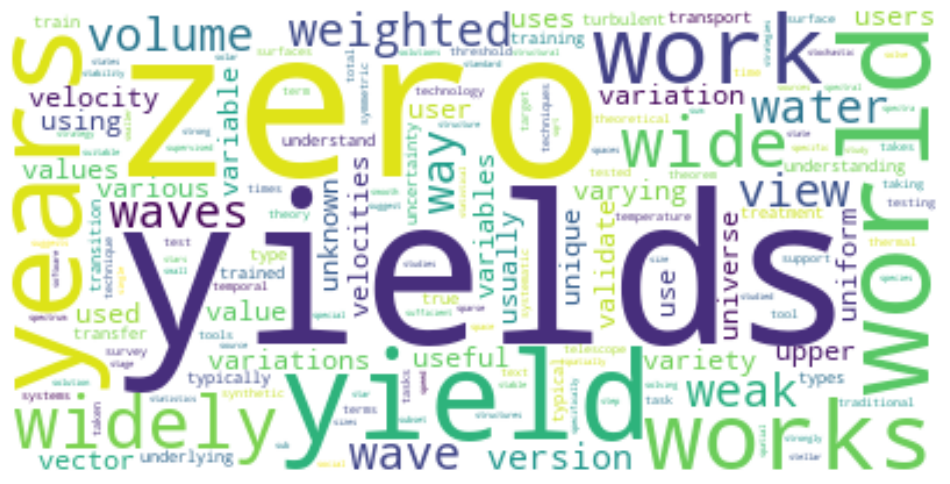

In [11]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(cvec.vocabulary_)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis('off');

### Visualización

Claramente no podemos hacer un análisis exploratorio de las variables o una visualización detallada, asi que utilizaremos reducción de dimensionalidad para observar la relación entre los atributos y las clases.

Comenzaremos con PCA aunque claramente los atributos no se distribuyen de manera gausiana.

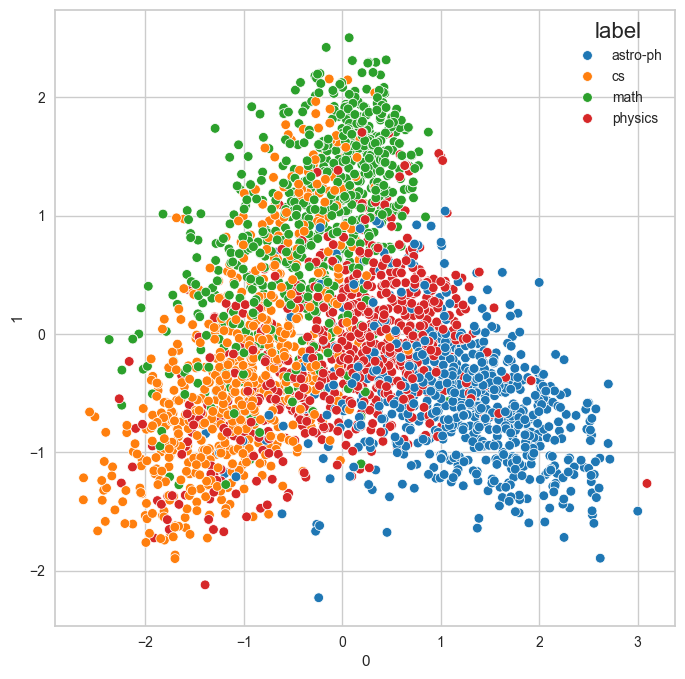

In [12]:
pca = PCA()
tdata = pca.fit_transform(np.asarray(X_train_v.todense()))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':y_train})],axis=1)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

Claramente tampoco podemos esperar que unos pocos componentes expliquen la variancia de los datos.

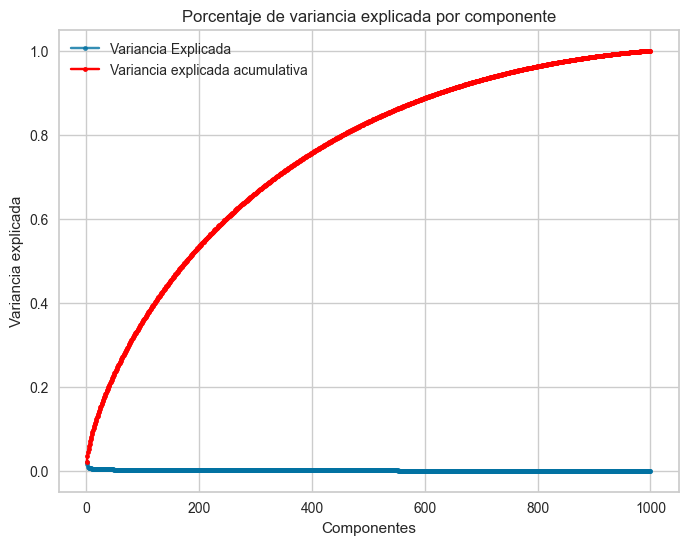

In [13]:
fig = plt.figure(figsize=(8,6));
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),pca.explained_variance_ratio_ ,alpha=0.8,marker='.',label="Variancia Explicada");
y_label = plt.ylabel('Variancia explicada');
x_label = plt.xlabel('Componentes');
plt.plot(range(1,len(pca.explained_variance_ratio_ )+1),
         np.cumsum(pca.explained_variance_ratio_),
         c='red',marker='.',
         label="Variancia explicada acumulativa");
plt.legend();
plt.title('Porcentaje de variancia explicada por componente');

Podemos ver que hay cierta separabilidad entre las clases, también la proyección nos da una idea de las relaciones entre ellas.

Podemos usar también t-SNE dado que trabaja directamente con distancias. Lo inicializaremos con PCA.

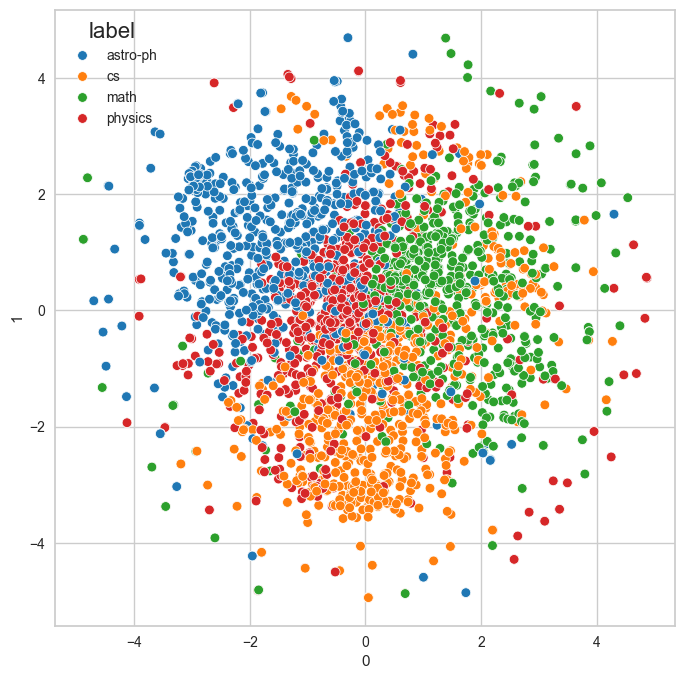

In [14]:
tsne = TSNE(init='pca')
tdata = tsne.fit_transform(np.asarray(X_train_v.todense()))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':y_train})],axis=1);
fig = plt.figure(figsize=(8,8));
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

### Support Vector Machines

La idea de una SVM es encontrar el separador óptimo entre las clases que corresponderá con el hiperplano que maximice el margen entre ellas. Vimos que esto se puede obtener resolviendo un problema de programación cuadrática.

Si las clases no son linealemente separables (como probablemente pasa en nuestro caso) podemos poner un límite al error que comete el clasificador para encontrar el separador. También podemos utilizar diferentes kernels que aumentan la dimensionalidad del espacio para obtener más fácilmente el separador.

En este caso probaremos la SVM lineal, la SVM con kernel polinómico y la SVM con kernel RBF. 

Desde el punto de vista de la interpretabilidad sería mejor la SVM lineal, pero interpretar los pesos en este problema puede ser complicado, veremos más adelante como se pueden obtener explicaciones de la clasificación de ejemplos en este caso.

#### Kernel lineal

Empezaremos con la SVM lineal.

Antes de usarla lo usual es normalizar los datos para usar la SVM. En este caso no lo necesitamos ya que los datos son binarios, pero podría ayudar a la convergencia en otros casos.


In [15]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc = SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train_v, y_train_l);

In [16]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
11,{'C': 0.013803842646028845},0.784,1
3,{'C': 0.007943282347242814},0.782,2
4,{'C': 0.023988329190194897},0.776,3
8,{'C': 0.0034673685045253167},0.772,4
1,{'C': 0.03630780547701014},0.765,5


Podemos ver que la separabilidad no es perfecta con este número de atributos, los artículos de astrofísica parecen ser los que se clasficican mejor.

In [17]:
print(classification_report(y_test_l, lsvc_gs.predict(X_test_v), target_names=cls))
results_df = save_results(lsvc_gs, X_test_v, y_test_l, 'linear SVM binary', results_df)

              precision    recall  f1-score   support

    astro-ph       0.90      0.86      0.88       300
          cs       0.75      0.72      0.73       300
        math       0.73      0.79      0.76       300
     physics       0.72      0.71      0.72       300

    accuracy                           0.77      1200
   macro avg       0.77      0.77      0.77      1200
weighted avg       0.77      0.77      0.77      1200



Los artículos de física son los que tienen más confusión con el resto, los de astrofísica no se parecen tanto a los de CS o de matematicas y entre estos dos también hay cierto solapamiento.

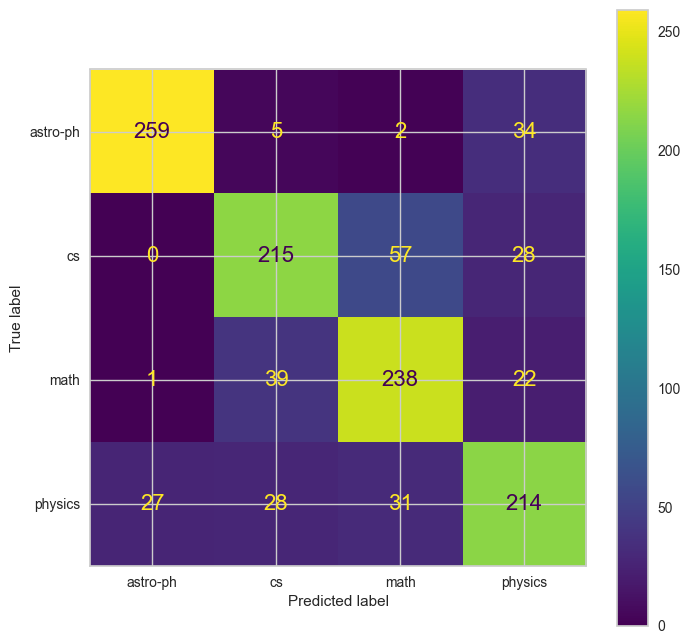

In [18]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test_v, y_test_l, display_labels=cls, ax=plt.subplot());

En la curva ROC también podemos ver que los articulos de astrofísica son los que se distinguen mejor.

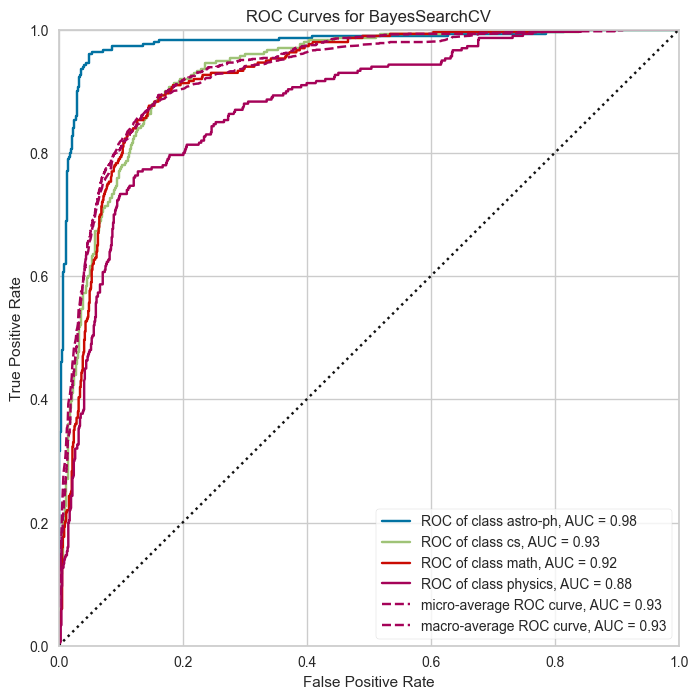

In [19]:
plt.figure(figsize=(8,8));
roc_auc(lsvc_gs, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);

#### Kernels polinómicos

Ahora probaremos usando kernels no lineales empezando por kernels polinómicos cuadráticos y cúbicos

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3]}

psvc =  SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs = BayesSearchCV(psvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvc_gs.fit(X_train_v, y_train_l);

Dependiendo de la exploración podemos llegar a un resultado marginalmente mejor

In [ ]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Obtenemos un resultado ligeramente mejor en el test, hemos perdido algo en los artículos de astrofísica, pero hemos ganado algo en el resto

In [ ]:
print(classification_report(y_test_l, psvc_gs.predict(X_test_v), target_names=cls))
results_df = save_results(psvc_gs, X_test_v, y_test_l, 'polynomial SVM binary', results_df)

Podemos ver un patron de confusión similar

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(psvc_gs, X_test_v, y_test_l, display_labels=cls, ax=plt.subplot());

La curva ROC parece bastante similar.

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(psvc_gs, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);

#### Kernel RBF

Probamos ahora con el kernel gausiano

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs.fit(X_train_v, y_train_l);

Dependiendo de la exploración vemos otra ligera mejora en el resultado

In [ ]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

En el test se equilibran algo mas los resultados entre las clases con más confusión.

In [ ]:
print(classification_report(y_test_l, rbsvc_gs.predict(X_test_v), target_names=cls))
results_df = save_results(rbsvc_gs, X_test_v, y_test_l, 'RBF SVM binary', results_df)

Probablemente hay artículos que combinan más de un tema y eso hace difícil distinguirlos.

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs, X_test_v, y_test_l, display_labels=cls, ax=plt.subplot());

La curva ROC es ligeramente mejor para alguna clase

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs, X_train_v, y_train_l, X_test_v, y_test_l, classes=cls);

### TF-IDF como atributos

Ahora podemos usar la frecuencia de las palabras en los documentos (TF) y su fecuencia en el corpus (IDF) como atributos. Eso hará que no solo usemos las palabras que aparecen en los textos, sino que también tengamos en cuenta su importancia en el documento y en el corpus de texto.

In [ ]:
cvect = TfidfVectorizer(stop_words='english', max_features=voc_size)

X_train_vt = cvect.fit_transform(X_train)
X_test_vt = cvect.transform(X_test)
X_train_vt.shape

Podemos visualizar el vocabulario que tenemos, hay ligeras diferencias dado que estamos dando ahora pesos a las palabras.

In [ ]:
from wordcloud import WordCloud

wordcloud = WordCloud(background_color='white').generate_from_frequencies(cvect.vocabulary_)
plt.figure(figsize=(12,8))
plt.imshow(wordcloud, interpolation='bilinear');
plt.axis('off');

### Visualización

La proyección de PCA ha cambiado ligeramente, la relación espacial entre clase se ha mantenido, pero los ejemplos se han dispersado algo más con menor variancia en algunas direcciones.

In [ ]:
pca = PCA()
tdata = pca.fit_transform(np.asarray(X_train_vt.todense()))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':y_train})],axis=1)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');


Podemos usar también t-SNE inicializado con PCA. 

In [ ]:
tsne = TSNE(init='pca')
tdata = tsne.fit_transform(np.asarray(X_train_vt.todense()))
dfdata = pd.concat([pd.DataFrame(tdata[:,:2]),pd.DataFrame({'label':y_train})],axis=1)
fig = plt.figure(figsize=(8,8))
sns.scatterplot(x=0, y=1, hue='label', data=dfdata, palette='tab10');

Podemos ver las mismas relaciones, quizás algo más de separabilidad que antes.

### Support Vector Machines - TFIDF

#### SVM lineal

Vamos a aplicar las diferentes SVMs a esta nueva representación empezando con la SVM lineal.

En este caso no tenemos datos binarios ahora si podemos normalizarlos, habitualmente eso ayuda a la convergencia.

In [ ]:
mmscaler = MinMaxScaler()

X_train_vt_m = mmscaler.fit_transform(np.asarray(X_train_vt.todense()))
X_test_vt_m = mmscaler.transform(np.asarray(X_test_vt.todense()))

In [ ]:
param = {'C':10**np.linspace(-3,3,101)}

lsvc =  SVC(kernel='linear', max_iter=25000, random_state=0)
lsvc_gs = BayesSearchCV(lsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
lsvc_gs.fit(X_train_vt_m, y_train_l);

In [ ]:
show_html(pd.DataFrame(lsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

No hay una gran diferencia con la otra represesentación

In [ ]:
print(classification_report(y_test_l, lsvc_gs.predict(X_test_vt_m), target_names=cls))
results_df = save_results(lsvc_gs, X_test_vt_m, y_test_l, 'linear SVM TFIDF', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lsvc_gs, X_test_vt_m, y_test_l, display_labels=cls, ax=plt.subplot());

La confusión entre clases sigue siendo parecida y la curva ROC parece algo más suave en la clase más difícil

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(lsvc_gs, X_train_vt_m, y_train_l, X_test_vt_m, y_test_l, classes=cls);

#### Kernel Polinómico

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'degree':[2,3]}

psvc =  SVC(kernel='poly', max_iter=25000, random_state=0)
psvc_gs = BayesSearchCV(psvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
psvc_gs.fit(X_train_vt_m, y_train_l);

In [ ]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Los resultados son algo peores, per no hay gran diferencia

In [ ]:
print(classification_report(y_test_l, psvc_gs.predict(X_test_vt_m), target_names=cls))
results_df = save_results(psvc_gs, X_test_vt_m, y_test_l, 'polynomial SVM TFIDF', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(psvc_gs, X_test_vt_m, y_test_l, display_labels=cls, ax=plt.subplot());

Podemos ver que la curva ROC de la clase más difícil se ha acercado a la de las clases CS y math, se ha equilibrado más la relacón entre precisión y recuperación.

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(psvc_gs, X_train_vt_m, y_train_l, X_test_vt_m, y_test_l, classes=cls);

### Kernel RBF

In [ ]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto']}

rbsvc =  SVC(kernel='rbf', max_iter=25000, random_state=0)
rbsvc_gs = BayesSearchCV(rbsvc,param,n_iter=niter, cv=cv, n_jobs=-1, refit=True, random_state=0)
rbsvc_gs.fit(X_train_vt_m, y_train_l);

In [ ]:
show_html(pd.DataFrame(rbsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

Tenemos resultados también parecidos a los de antes

In [ ]:
print(classification_report(y_test_l, rbsvc_gs.predict(X_test_vt_m), target_names=cls))
results_df = save_results(rbsvc_gs, X_test_vt_m, y_test_l, 'RBF SVM TFIDF', results_df)

In [ ]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(rbsvc_gs, X_test_vt_m, y_test_l, display_labels=cls, ax=plt.subplot());

In [ ]:
plt.figure(figsize=(8,8));
roc_auc(rbsvc_gs, X_train_vt_m, y_train_l, X_test_vt_m, y_test_l, classes=cls);

Estos son los resultados finales podemos ver que el acierto en la validación cruzada y en el test son muy parecidos, ninguno de los modelos se ha sobre especializado. 

Si elegimos el mejor modelos según el acierto en el conjunto de test entonces 
nos decidiriamos por la SVM con kernel RBF que da un resultado ligeramente mejor. Podemos ver que también es mejor en el resto de medidas.

In [ ]:
results_df.sort_values(by=['test acc'], ascending=False)

## Sección 2: Energy Data - Regresión

Como vimos en la última sesión de laboratorio, un problema que se puede resolver mediante regresión es la predicción de series de tiempo.

En este tipo de problemas queremos predecir valores de un momento en el tiempo a partir de los valores anteriores. En este caso debemos decidir cuantos instantes anteriores utilizamos y si utilizamos solo la variable objetivo o añadimos también otras variables que tengamos disponibles.

Si recordais, en este problema queremos predecir el consumo de energia de los electrodomesticos de una casa. Tenemos muchos otros atributos, pero en este caso solo utilizaremos la variable objetivo. Podéis encontrar la documentación de este conjunto de datos aqui (https://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction)

Podemos usar la SVM para regresión para realizar la misma tarea que en el notebook de Knn y MLP.

In [5]:
from numpy.lib.stride_tricks import sliding_window_view
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, make_scorer
pd.set_option('display.precision', 5)

niter = 15
cv = 5

In [6]:
data = load_energy()

In [7]:
energy = data.loc[:,'Appliances']

Realizamos el mismo preproceso para poder comparar los resultados, de todas formas diferentes preprocesos pueden tener un impacto en la calidad del resultado. Una posibilidad es usar la serie a predecir sin preprocesar, es algo que podeis hacer vosotros.

In [8]:
e_train, e_test =  energy.iloc[:12000], energy.iloc[12000:]

w = 4

sdscaler = MinMaxScaler()

e_train_s = sdscaler.fit_transform(e_train.to_numpy().reshape(-1, 1))
e_test_s = sdscaler.transform(e_test.to_numpy().reshape(-1, 1))

windows_train = sliding_window_view(e_train_s, w+1, axis=0).copy()
X_train_w, y_train_w = windows_train.squeeze()[:,:-1], windows_train.squeeze()[:,-1]

windows_test = sliding_window_view(e_test_s, w+1, axis=0).copy()
X_test_w, y_test_w = windows_test.squeeze()[:,:-1], windows_test.squeeze()[:,-1]

#### Kernel lineal

La SVM para regresión utiliza la epsilon insensitive loss. El valor del parámetro `epsilon` depende de la escala de los datos, en este caso [0,1], dependiendo del valor que le demos en este caso es posible que eso nos de un valor mínimo que pueda generar la regresión, asi que hemos de tener cuidado al usarlo y ver el efecto que tiene en la predicción.

In [9]:
param = {'C':10**np.linspace(-3,3,101), 'epsilon':np.linspace(0,0.01,11)}

lsvr =  SVR(kernel='linear', max_iter=25000, cache_size=2000)
lsvr_gs = BayesSearchCV(lsvr,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=cv, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)
lsvr_gs.fit(X_train_w, y_train_w);

In [10]:
show_html(pd.DataFrame(lsvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())


,params,mean_test_score,rank_test_score
7,"{'C': 1.1481536214968828, 'epsilon': 0.005}",-0.00393,1
9,"{'C': 0.16595869074375597, 'epsilon': 0.004}",-0.00393,2
0,"{'C': 1.513561248436207, 'epsilon': 0.007}",-0.00394,3
1,"{'C': 0.03630780547701014, 'epsilon': 0.01}",-0.00394,4
12,"{'C': 6.918309709189362, 'epsilon': 0.01}",-0.00394,5


Podemos ver que tenemos una predicción parecida a la de los otros dos modelos, ligeramente peor.

In [11]:
mean_squared_error(y_test_w,lsvr_gs.predict(X_test_w)), mean_absolute_error(y_test_w,lsvr_gs.predict(X_test_w))

(0.0037123357950668468, 0.024390076575483595)

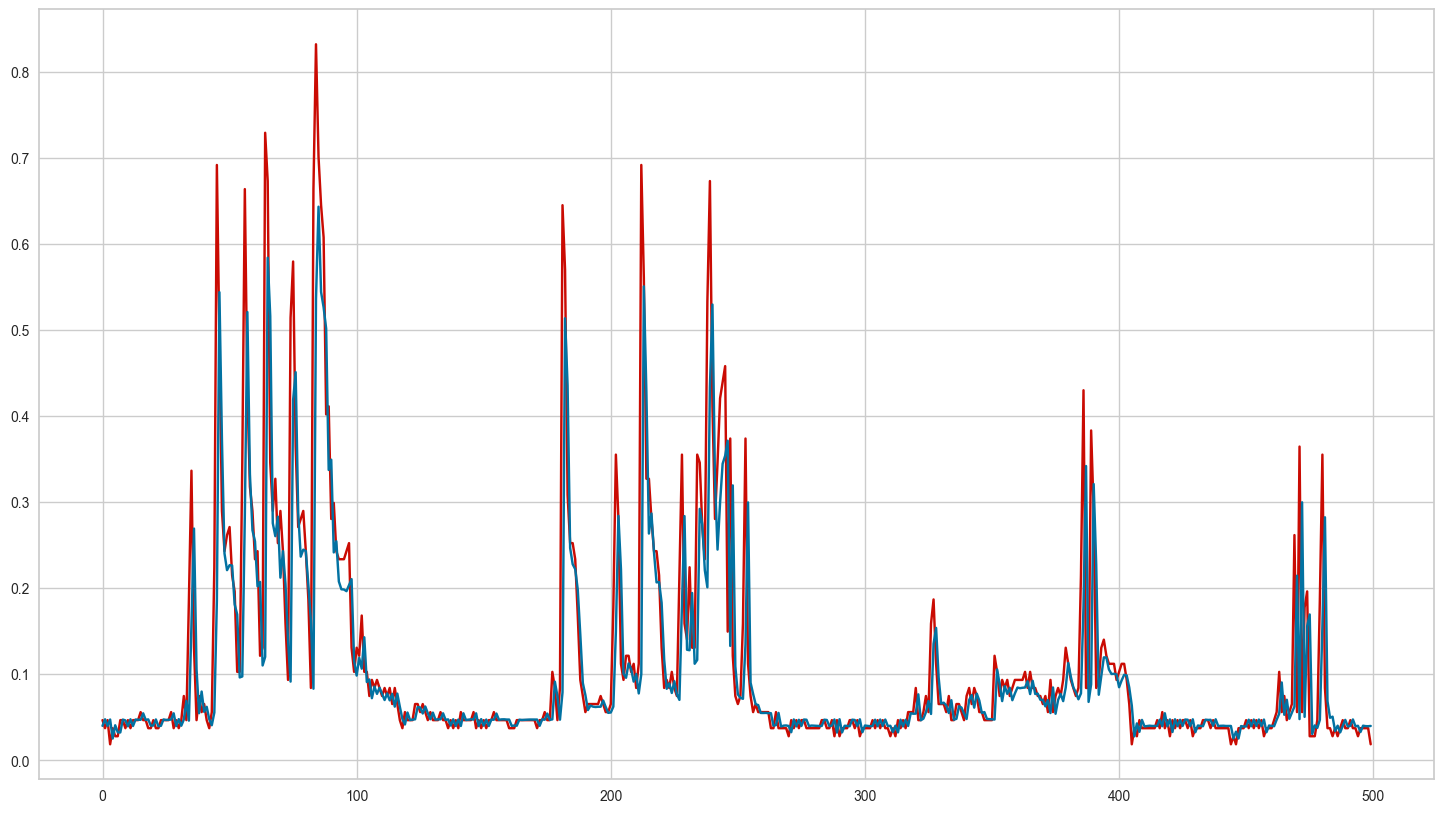

In [12]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r');
plt.plot(lsvr_gs.predict(X_test_w[:500,:]),'b');

Podemos ver también que la predicción en el conjunto de test también va siguiendo los valores reales.

En los valores más bajos de la serie podemos ver que muchas veces la predicción es casi constante, eso puede tener que ver con el valor de `epsilon` que estamos usando. Eso no quiere decir que sea un problema, los valores mas bajos podrían ser básicamente ruido así que una predicción más suave podría ser más plausible, pero depende de la aplicación.

### Kernel RBF

Probamos ahora con el kernel RBF.

In [13]:
param = {'C':10**np.linspace(-3,3,101), 'gamma':['scale','auto'], 'epsilon':np.linspace(0,0.01,11)}

rbsvr =  SVR(kernel='rbf', max_iter=50000, cache_size=2000)
rbsvr_gs = BayesSearchCV(rbsvr,param,n_iter=niter, 
                        cv=TimeSeriesSplit(n_splits=cv, gap=w+1), 
                        scoring=make_scorer(mean_squared_error, greater_is_better=False),
                        n_jobs=-1, 
                        refit=True, random_state=0)
rbsvr_gs.fit(X_train_w, y_train_w);

In [14]:
show_html(pd.DataFrame(rbsvr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())


,params,mean_test_score,rank_test_score
1,"{'C': 0.03630780547701014, 'epsilon': 0.01, 'gamma': 'scale'}",-0.00368,1
4,"{'C': 0.023988329190194897, 'epsilon': 0.002, 'gamma': 'scale'}",-0.00373,2
12,"{'C': 1.9952623149688788, 'epsilon': 0.005, 'gamma': 'auto'}",-0.00385,3
2,"{'C': 1.513561248436207, 'epsilon': 0.001, 'gamma': 'auto'}",-0.00386,4
9,"{'C': 0.16595869074375597, 'epsilon': 0.004, 'gamma': 'auto'}",-0.00387,5


El resultado es ligeramente mejor, más cerca al de los otros dos modelos.

In [15]:
mean_squared_error(y_test_w,rbsvr_gs.predict(X_test_w)), mean_absolute_error(y_test_w,rbsvr_gs.predict(X_test_w))

(0.0035315385456156944, 0.02318724911188652)

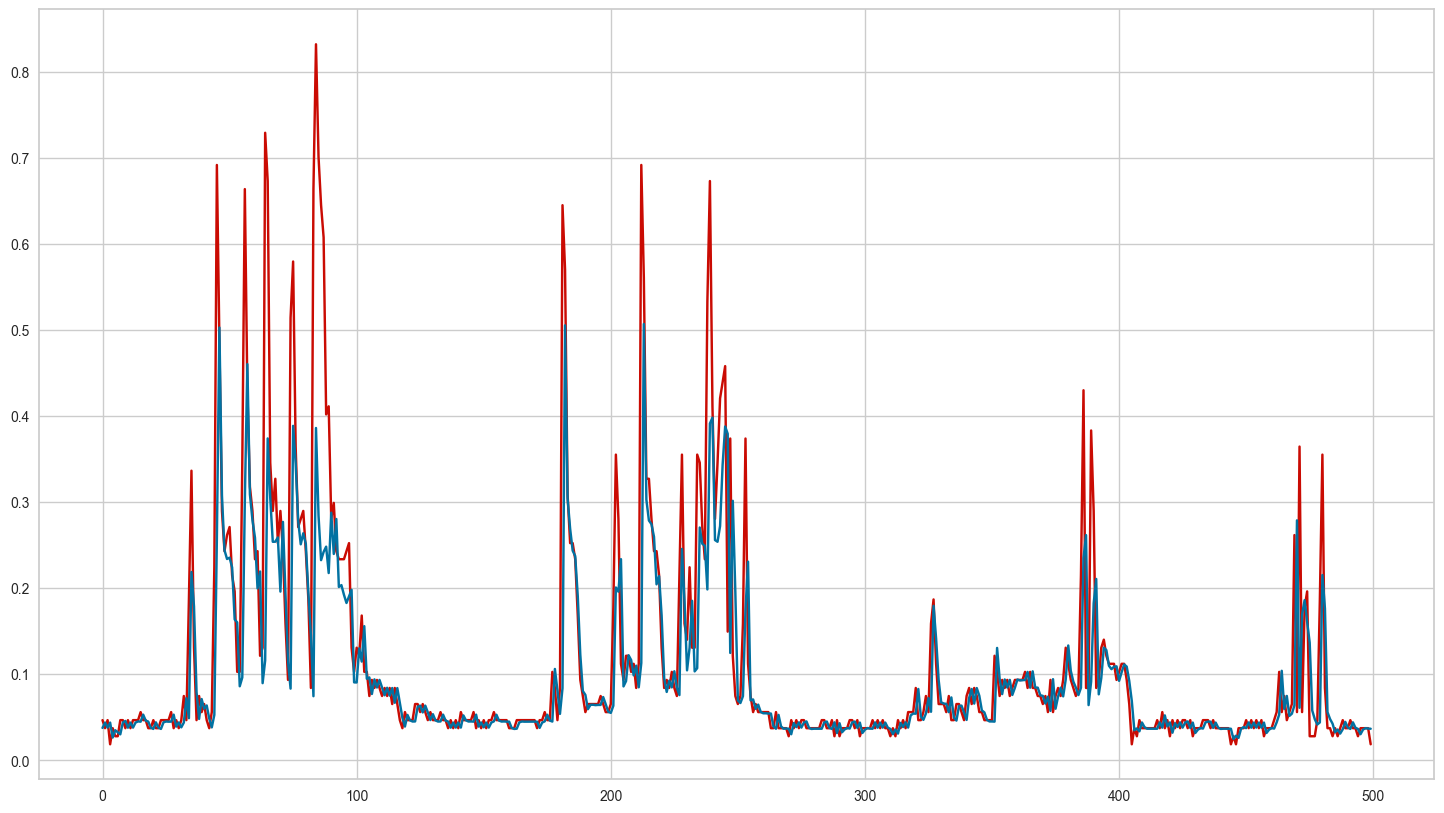

In [16]:
plt.figure(figsize=(18,10))
plt.plot(y_test_w[:500],'r');
plt.plot(rbsvr_gs.predict(X_test_w[:500,:]),'b');

También sigue bastante bien los datos de test.

In [17]:

print(f"Total Running time {timedelta(seconds=(time() - init_time))}")

Total Running time 0:06:25.368526
